# TensorBoard Integration with LatticeMC

This notebook demonstrates how to use TensorBoard to visualize simulation progress with immediate logging.

In [1]:
import numpy as np
from decimal import Decimal

In [2]:
from latticemc.definitions import Lattice, LatticeState, OrderParametersHistory, DefiningParameters
from latticemc.lattice_tools import initialize_partially_ordered
from latticemc.random_quaternion import random_quaternion
from latticemc.updaters import AcceptanceRateWiggleRateAdjustor, RandomWiggleRateAdjustor
from latticemc.parallel import SimulationRunner, ProgressBarMode

## Set up simulation with TensorBoard logging enabled

We'll create a simulation with multiple temperatures and enable TensorBoard logging.
With the new immediate logging approach, data is logged as soon as it's received from simulation processes.

In [3]:
# Setup simulation with multiple temperatures
temperatures = np.arange(0.3, 1.7, 0.1)  # Fewer temps for faster demo
states = [LatticeState(parameters=DefiningParameters(temperature=round(Decimal(t), 2), lam=Decimal(0.3), tau=1),
                       lattice=Lattice(10, 10, 10))  # Smaller lattice for faster demo
          for t in temperatures]
for state in states:
    initialize_partially_ordered(state.lattice, x=random_quaternion(1.0))

order_parameters_history = {state.parameters: OrderParametersHistory(state.lattice.size) for state in states}

In [4]:
# Setup updaters
per_state_updaters = [
    AcceptanceRateWiggleRateAdjustor(how_often=20, since_when=20),
    RandomWiggleRateAdjustor(scale=0.001, how_often=100, since_when=100, until=1000),
    RandomWiggleRateAdjustor(scale=1.0, reset_value=1.0, how_often=500, since_when=500, until=1000)
]


## Thermalization

In [5]:
# Setup simulation runner for thermalization
order_parameters_history_thermalization = {state.parameters: OrderParametersHistory(state.lattice.size) for state in states}
runner_thermalization = SimulationRunner(initial_states=states,
                          order_parameters_history=order_parameters_history_thermalization,
                          cycles=10000,
                          per_state_updaters=per_state_updaters,
                          progress_bar_mode=ProgressBarMode.NOTEBOOK,
                          report_order_parameters_every=500,
                          report_state_every=500,
                          parallel_tempering_interval=10,  # More frequent PT swaps during thermalization
                          save_interval=500,
                          working_folder='./tensorboard_demo/thermalization',
                          plot_recent_points=500)
runner_thermalization.run()
runner_thermalization.finished_gracefully()

Overall Progress:   0%|          | 0/140000 [00:00<?, ?steps/s]

Sim 0 (T=0.300):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 1 (T=0.400):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 2 (T=0.500):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 3 (T=0.600):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 4 (T=0.700):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 5 (T=0.800):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 6 (T=0.900):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 7 (T=1.000):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 8 (T=1.100):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 9 (T=1.200):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 10 (T=1.300):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 11 (T=1.400):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 12 (T=1.500):   0%|          | 0/10000 [00:00<?, ?steps/s]

Sim 13 (T=1.600):   0%|          | 0/10000 [00:00<?, ?steps/s]

All simulation processes finished gracefully
All simulation processes finished gracefully


True

## Configure main simulation

In [6]:
# Setup updaters
per_state_updaters = [
    AcceptanceRateWiggleRateAdjustor(how_often=20, since_when=20),
]

runner = SimulationRunner(states,
                         order_parameters_history,
                         cycles=50000,
                         report_order_parameters_every=50,
                         report_state_every=50,
                         per_state_updaters=per_state_updaters,
                         parallel_tempering_interval=50,
                         save_interval=100,
                         plot_recent_points=1000,
                         working_folder='./tensorboard_demo',  # TensorBoard logs go to ./tensorboard_demo/tensorboard
                         progress_bar_mode=ProgressBarMode.NOTEBOOK)

## Start the simulation

Run the simulation and TensorBoard logging will happen automatically as data is received:
- Order parameters are logged immediately when received
- Fluctuations are logged immediately when received  
- Lattice states (including energy and acceptance rates) are logged when state updates are received

## Progress Bars

The simulation now includes progress bars to track the simulation progress:
- **Main progress bar**: Shows overall simulation progress across all temperatures
- **Per-simulation progress bars**: Individual progress for each temperature simulation

These progress bars work seamlessly with TensorBoard logging and provide real-time feedback on simulation status.

In [ ]:
# Start the simulation
runner.start()

Overall Progress:   0%|          | 0/700000 [00:00<?, ?steps/s]

Sim 0 (T=0.300):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 1 (T=0.400):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 2 (T=0.500):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 3 (T=0.600):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 4 (T=0.700):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 5 (T=0.800):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 6 (T=0.900):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 7 (T=1.000):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 8 (T=1.100):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 9 (T=1.200):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 10 (T=1.300):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 11 (T=1.400):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 12 (T=1.500):   0%|          | 0/50000 [00:00<?, ?steps/s]

Sim 13 (T=1.600):   0%|          | 0/50000 [00:00<?, ?steps/s]

All simulation processes finished gracefully


## Launch TensorBoard

While the simulation is running, you can launch TensorBoard in a new terminal to visualize the progress:

```bash
tensorboard --logdir=./tensorboard_demo/tensorboard
```

This will start a local server, typically at http://localhost:6006, where you can view the visualizations.

### What you'll see in TensorBoard:

1. **Order Parameters**: Real-time plots of energy, q0, q2, w, p, d322 for each temperature
2. **Fluctuations**: Real-time fluctuation measurements for each order parameter
3. **Acceptance Rates**: Live monitoring of orientation and parity move acceptance rates
4. **Lattice Energy**: Energy values from lattice averages updated as states are received

In [ ]:
# If you want to stop the simulation early
# runner.stop()

In [ ]:
# Check if the simulation is still running
runner.alive()

In [ ]:
# When done, check if it finished properly
runner.finished_gracefully()

# Analyzing Results with Pandas

After the simulation completes, you can analyze the comprehensive data that was saved in CSV and XZ formats. The simulation creates several types of data files for analysis.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load the final parameter summary data (contains decorrelated averages over full history)
data_path = Path('./tensorboard_demo/data/')

# Load the comprehensive parameter summary table
# This contains one row per parameter set with all averaged quantities
df_summary = pd.read_pickle(data_path / 'parameter_summary_final.xz')

# Display basic info about the data
print(f"Data shape: {df_summary.shape}")
print(f"Temperature range: {df_summary['temperature'].min():.2f} - {df_summary['temperature'].max():.2f}")
print("\nAvailable columns:")
print([col for col in df_summary.columns if col.startswith(('avg_', 'fluct_', 'hist_fluct_'))])

Data shape: (14, 24)
Temperature range: 0.30 - 1.60

Available columns:
['avg_energy', 'avg_q0', 'avg_q2', 'avg_w', 'avg_p', 'avg_d322', 'fluct_energy', 'fluct_q0', 'fluct_q2', 'fluct_w', 'fluct_p', 'fluct_d322', 'hist_fluct_energy', 'hist_fluct_q0', 'hist_fluct_q2', 'hist_fluct_w', 'hist_fluct_p', 'hist_fluct_d322']


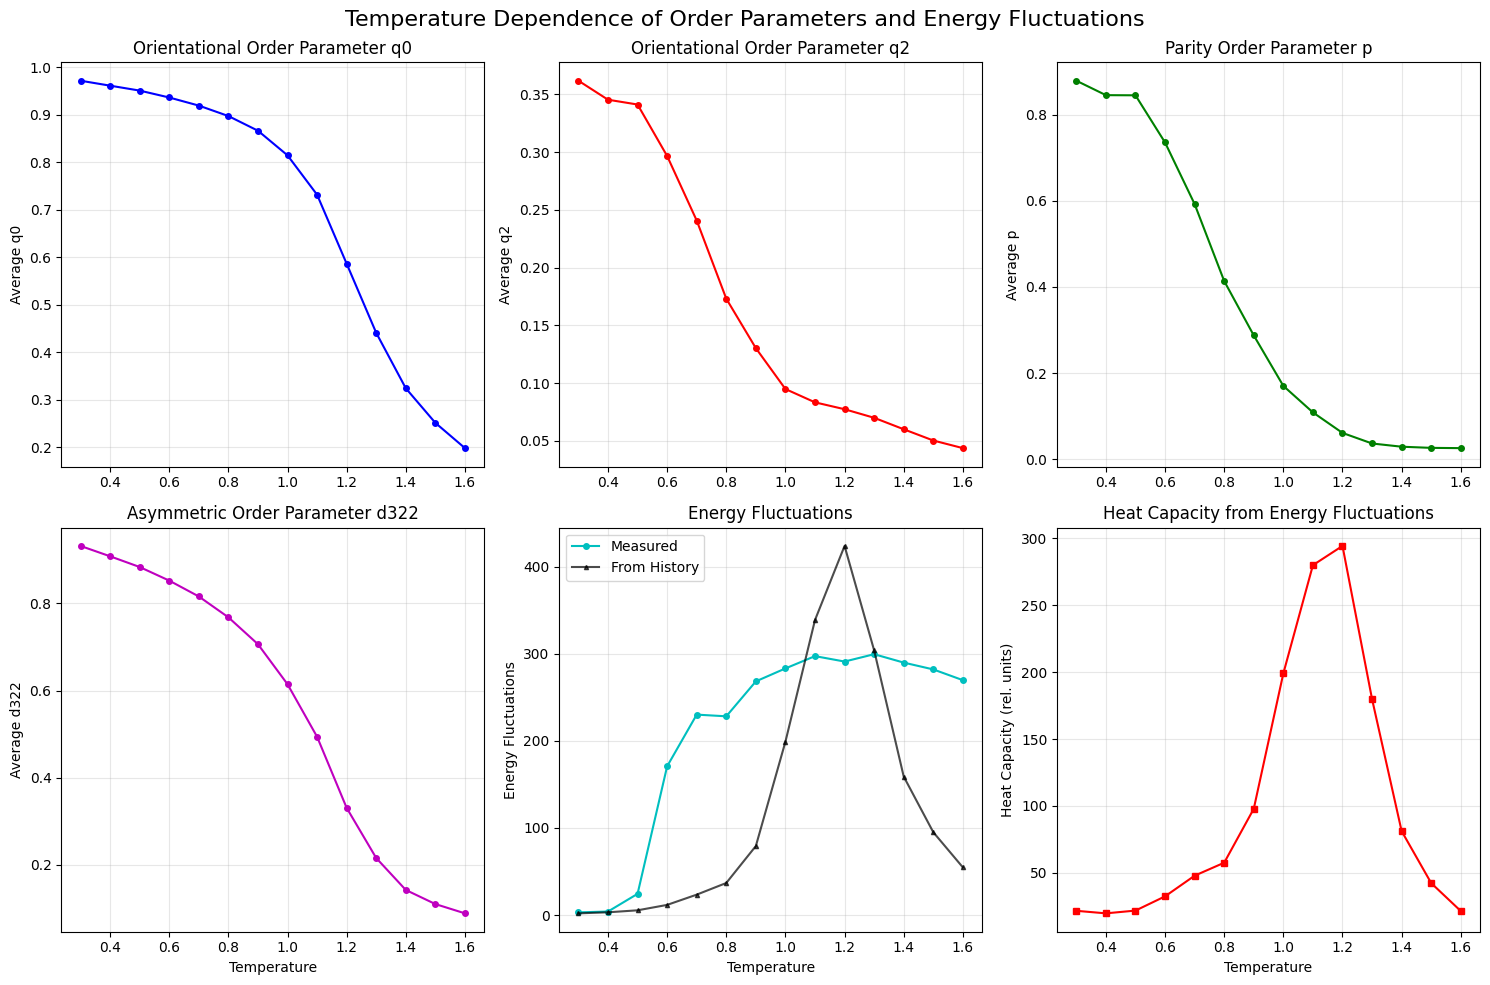

In [ ]:
%matplotlib inline
# Create comprehensive temperature plots showing order parameters and energy fluctuations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Temperature Dependence of Order Parameters and Energy Fluctuations', fontsize=16)

# Sort data by temperature for smooth curves
df_sorted = df_summary.sort_values('temperature')
temps = df_sorted['temperature']

# Plot order parameters: q0, q2, p, d322
axes[0, 0].plot(temps, df_sorted['avg_q0'], 'bo-', label='q0', markersize=4)
axes[0, 0].set_ylabel('Average q0')
axes[0, 0].set_title('Orientational Order Parameter q0')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(temps, df_sorted['avg_q2'], 'ro-', label='q2', markersize=4)
axes[0, 1].set_ylabel('Average q2')
axes[0, 1].set_title('Orientational Order Parameter q2')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(temps, df_sorted['avg_p'], 'go-', label='p', markersize=4)
axes[0, 2].set_ylabel('Average p')
axes[0, 2].set_title('Parity Order Parameter p')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].plot(temps, df_sorted['avg_d322'], 'mo-', label='d322', markersize=4)
axes[1, 0].set_ylabel('Average d322')
axes[1, 0].set_xlabel('Temperature')
axes[1, 0].set_title('Asymmetric Order Parameter d322')
axes[1, 0].grid(True, alpha=0.3)

# Plot energy fluctuations (both measured during simulation and calculated from history)
axes[1, 1].plot(temps, df_sorted['fluct_energy'], 'co-', label='Measured', markersize=4)
axes[1, 1].plot(temps, df_sorted['hist_fluct_energy'], 'k^-', label='From History', markersize=3, alpha=0.7)
axes[1, 1].set_ylabel('Energy Fluctuations')
axes[1, 1].set_xlabel('Temperature')
axes[1, 1].set_title('Energy Fluctuations')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Heat capacity (proportional to energy fluctuations / T^2)
heat_capacity = df_sorted['hist_fluct_energy'] / (df_sorted['temperature']**2)
axes[1, 2].plot(temps, heat_capacity, 'rs-', label='C ∝ ⟨ΔE²⟩/T²', markersize=4)
axes[1, 2].set_ylabel('Heat Capacity (rel. units)')
axes[1, 2].set_xlabel('Temperature')
axes[1, 2].set_title('Heat Capacity from Energy Fluctuations')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()

Found 14 parameter sets:
  T0.30_lam0.30_tau1.00
  T0.40_lam0.30_tau1.00
  T0.50_lam0.30_tau1.00
  T0.60_lam0.30_tau1.00
  T0.70_lam0.30_tau1.00

Analyzing detailed time-series for: T0.80_lam0.30_tau1.00


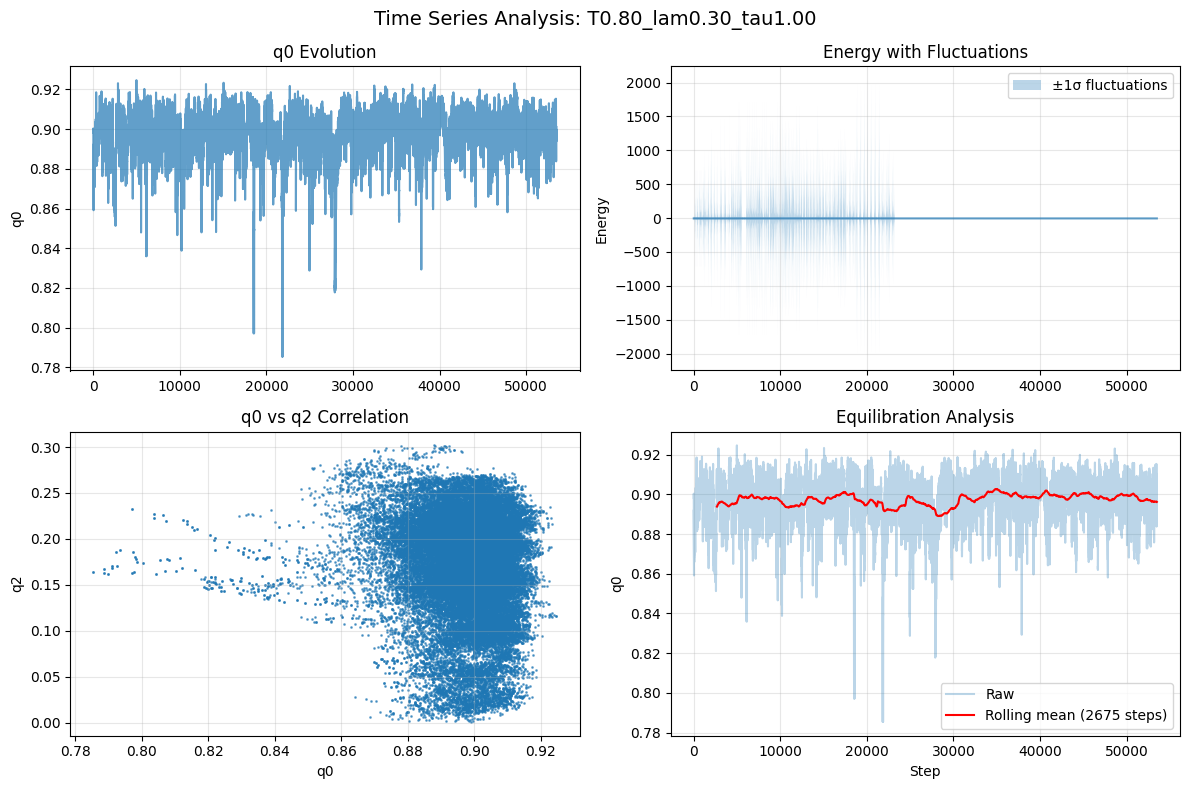


Time-series statistics:
Total steps: 53500
Final q0: 0.9011
Average energy: -4.6033


In [12]:
# Analyze time-series data for specific temperatures
# Load detailed time-series data for a specific parameter set (e.g., T=0.8)

# Find available parameter folders
param_folders = list(Path('./tensorboard_demo/parameters/').glob('T*'))
print(f"Found {len(param_folders)} parameter sets:")
for folder in sorted(param_folders)[:5]:  # Show first 5
    print(f"  {folder.name}")

# Load time-series data for a mid-temperature case (around T=0.8)
if param_folders:
    # Find folder with temperature closest to 0.8
    target_temp = 0.8
    best_folder = min(param_folders, 
                     key=lambda p: abs(float(p.name.split('_')[0][1:]) - target_temp))
    
    print(f"\nAnalyzing detailed time-series for: {best_folder.name}")
    
    # Load the complete time-series data
    timeseries_path = best_folder / 'data' / 'timeseries.xz'
    if timeseries_path.exists():
        df_timeseries = pd.read_pickle(timeseries_path)
        
        # Create time-series plots
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f'Time Series Analysis: {best_folder.name}', fontsize=14)
        
        # Plot order parameter evolution
        axes[0, 0].plot(df_timeseries['step'], df_timeseries['op_q0'], alpha=0.7)
        axes[0, 0].set_ylabel('q0')
        axes[0, 0].set_title('q0 Evolution')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot energy evolution with fluctuations
        axes[0, 1].plot(df_timeseries['step'], df_timeseries['op_energy'], alpha=0.7)
        axes[0, 1].fill_between(df_timeseries['step'], 
                               df_timeseries['op_energy'] - df_timeseries['fl_energy'],
                               df_timeseries['op_energy'] + df_timeseries['fl_energy'],
                               alpha=0.3, label='±1σ fluctuations')
        axes[0, 1].set_ylabel('Energy')
        axes[0, 1].set_title('Energy with Fluctuations')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot correlation between order parameters
        axes[1, 0].scatter(df_timeseries['op_q0'], df_timeseries['op_q2'], 
                          alpha=0.6, s=1)
        axes[1, 0].set_xlabel('q0')
        axes[1, 0].set_ylabel('q2')
        axes[1, 0].set_title('q0 vs q2 Correlation')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot running averages
        window = len(df_timeseries) // 20  # Use 5% window
        df_timeseries['q0_rolling'] = df_timeseries['op_q0'].rolling(window).mean()
        axes[1, 1].plot(df_timeseries['step'], df_timeseries['op_q0'], alpha=0.3, label='Raw')
        axes[1, 1].plot(df_timeseries['step'], df_timeseries['q0_rolling'], 'r-', label=f'Rolling mean ({window} steps)')
        axes[1, 1].set_xlabel('Step')
        axes[1, 1].set_ylabel('q0')
        axes[1, 1].set_title('Equilibration Analysis')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nTime-series statistics:")
        print(f"Total steps: {len(df_timeseries)}")
        print(f"Final q0: {df_timeseries['op_q0'].iloc[-1]:.4f}")
        print(f"Average energy: {df_timeseries['op_energy'].mean():.4f}")
    else:
        print(f"Time-series file not found at {timeseries_path}")
else:
    print("No parameter folders found. Make sure the simulation completed successfully.")